#**Initial Setting**
1.   Installation of freud package
2.   Add path









In [2]:
!pip install freud-analysis

     |████████████████████████████████| 5.1MB 7.1MB/s 


In [3]:
import sys
sys.path.append('/content/drive/MyDrive/Paperwork/Colab')

#**Definition**

In [4]:
from Definition_all import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
from scipy import interpolate
from shapely.geometry import Polygon, Point

#**Clusters**

## **Parameters**

In [5]:
minmum_particle_number_of_cluster = 150
voronoi_cutoff = 43
initial_frame = 400
everyframe = 10

##**Data**


---


**output data:** sorted_particles_frames

### Data collection and box size determination

In [6]:
with open('/content/drive/MyDrive/Paperwork/Coding/Droplets_Experiment/data/Exp_voronoi.pickle', 'rb') as file:
    data = pickle.load(file)
box_size = get_box_size(data)
print('box size = ', box_size)

box size =  [1023.0, 1024.0]


### Choosing the sepecific frames

In [7]:
frames = []
for f in range(initial_frame, len(data)-everyframe, everyframe):
    frames.append(np.array(data[f]))
frames = np.array(frames)
print('number of frames = ', len(frames))

number of frames =  42


### Get clusters and interfacial particles

In [8]:
cluster_frames = []
for frame in frames:
    cluster_frames.append(pick_clusters(frame,box_size, minmum_particle_number_of_cluster))
cluster_frames = np.array(cluster_frames)

In [9]:
interfacial_particles_frames = []
for i, frame in enumerate(cluster_frames):
    interfacial_particles_groups = []
    for group in frame:
        interfacial_particles = group[group[:,2] > voronoi_cutoff]
        interfacial_particles_groups.append(np.array(interfacial_particles))
    # print('No.%s frame has '%i, len(interfacial_particles_groups), 'groups')
    interfacial_particles_frames.append(np.array(interfacial_particles_groups))
interfacial_particles_frames = np.array(interfacial_particles_frames)

### Sort interfacial particles

In [10]:
sorted_particles_frames = []
for frame in interfacial_particles_frames:
    sorted_particles_group = []
    for group in frame:
        sorted_particles = sort_particles(group[:,:2], 50)
        sorted_particles_group.append(np.array(sorted_particles))
#         plt.plot(*sorted_particles.T[:2], '-o', mfc = 'k', ms = 3)
#     plt.show()
    sorted_particles_frames.append(np.array(sorted_particles_group))
sorted_particles_frames = np.array(sorted_particles_frames)

## **Clurvature analyses**

In [11]:
curv_interface_frames = []; curv_std_frames = []; curv_all = []
for frame in sorted_particles_frames:
    curv_interface_group = []; curv_std_group = []
    for interface in frame:
        curv_interface = []
        for i in range(1, len(interface)-1):
            p1 = interface[i-1]
            p2 = interface[i]
            p3 = interface[i+1]
            centre, radius = define_circle(p1, p2, p3)
            curv_interface.append(1/radius)
            curv_all.append(1/radius)
        curv_interface_group.append(curv_interface)
        curv_std_group.append(np.std(curv_interface))
    curv_interface_frames.append(curv_interface_group)
    curv_std_frames.append(curv_std_group)

In [12]:
cluster_size_frames = []
for frame in cluster_frames:
  cluster_size_group = []
  for group in frame:
    cluster_size_group.append(len(group))
  cluster_size_frames.append(cluster_size_group)

### PDF of Curvature

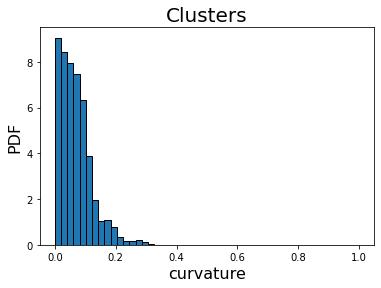

In [13]:
bins = np.linspace(0, 1.0, 50)
plt.hist(curv_all, bins = bins, ec = 'k', density= True)
plt.xlabel('curvature', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.title('Clusters', fontsize = 20)
plt.savefig('PDF_curvature_clusters.png', dpi = 150)


(49,) (49,)


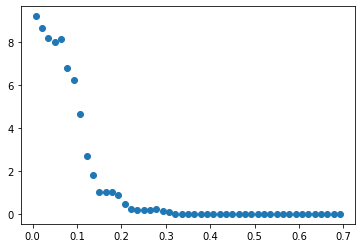

In [14]:
bins = np.linspace(0, 0.7, 50)
hist, bins = np.histogram(curv_all, bins = bins, density = True)
xdata = bins[:-1] + (bins[1] - bins[0]) /2
print(xdata.shape, hist.shape)
result = np.vstack((xdata, hist)).T
plt.plot(*result.T, 'o')
# with open('PDF_curvature_clusters_%s.pickle'%(minmum_particle_number_of_cluster), 'wb') as file:
#   pickle.dump(result, file)

###Standard deviation 

In [15]:
curv_std_all = []
for cluster_size, curv_std in zip(cluster_size_frames, curv_std_frames):
  for i, j in zip(cluster_size, curv_std):
    curv_std_all.append(np.array([i,j]))
curv_std_all = np.array(curv_std_all)

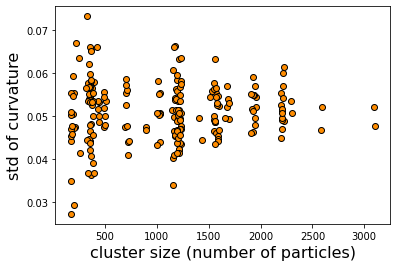

In [16]:
plt.plot(*curv_std_all.T, 'o', mec = 'k', mfc = 'darkorange')
plt.xlabel('cluster size (number of particles)', fontsize = 16)
plt.ylabel('std of curvature', fontsize = 16)
plt.savefig('std_curvature_clusters.png', dpi = 150)

#**Slab**

## **Parameters**

In [ ]:
box_size = [60, 120]
voronoi_cutoff = 0.5
initial_frame = 300
everyframe = 1

## **Data**

In [ ]:
with open('/content/drive/MyDrive/Paperwork/Coding/Simulation/data/slab.pickle','rb') as file:
  data = pickle.load(file)

In [ ]:
specific_data = data[1815:]
group_data = []
for frame in specific_data:
    group_data.append(frame[frame[:,3] == 1])
group_data = np.array(group_data)
box_size = [60, 120]

## **Curvature analyses**

In [ ]:
interfacial_particles_frames = []
box_size = np.array([60, 120]).reshape((2,1))
for frame in group_data:
    interface = frame[frame[:,4] > 0.4][:, 1:3]
    dnn = get_dnn_mean(interface, box_size)
    interfaces = get_interface_refined(interface, box_size, dnn * 4)
    # print(len(interfaces))
    sort_interface = []
    for inter in interfaces:
        x_indices = np.argsort(inter[:,0])
        inter_sort = inter[x_indices]
        for i in range(len(inter_sort)-1):
            p0_y = inter_sort[i][1]
            p1_y = inter_sort[i+1][1]
            dis = p1_y - p0_y
            if dis > box_size[1]/2:
                inter_sort[i+1, 1] = p1_y - box_size[1]
            if dis < -box_size[1]/2:
                inter_sort[i+1, 1] = p1_y + box_size[1]
        sort_interface.append(inter_sort)
    #     plt.plot(*inter_sort.T, 'o')
    # plt.show()
    interfacial_particles_frames.append(sort_interface)

In [ ]:
curv_std = []; all_curv = []
for frame in interfacial_particles_frames:
  for interface in frame:
    sorted_interface = sort_particles(interface, box_size[0]/2)
    curv = []
    for i in range(1, len(sorted_interface)-1):
      p1 = sorted_interface[i-1]
      p2 = sorted_interface[i]
      p3 = sorted_interface[i+1] 
      centre, radius = define_circle(p1, p2, p3)
      all_curv.append(1/radius)
      curv.append(1/radius)
    curv_std.append(np.std(curv))

### PDF of Curvature

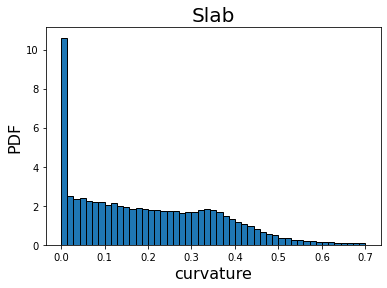

In [ ]:
bins = np.linspace(0, 0.7, 50)
plt.hist(all_curv, bins = bins, ec = 'k', density= True)
plt.xlabel('curvature', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.title('Slab', fontsize = 20)
plt.savefig('PDF_curvature_slab.png', dpi = 150)

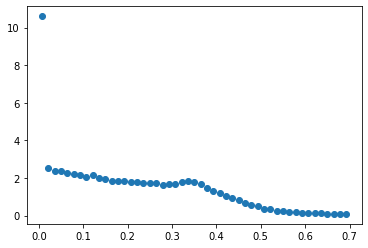

In [ ]:
hist, bins = np.histogram(all_curv, bins = bins, density = True)
xdata = bins[:-1] + (bins[1]- bins[0]) / 2
result = np.vstack((xdata, hist)).T
plt.plot(*result.T, 'o')
# with open('PDF_curvature_slab.pickle', 'wb') as file:
#   pickle.dump(result, file)

### PDF of std of curvature

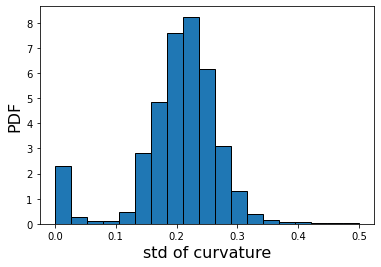

In [ ]:
bins = np.linspace(0, 0.5, 20)
plt.hist(curv_std, bins = bins, density=True, ec = 'k')
plt.xlabel('std of curvature', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.savefig('std_curvature_slab.png', dpi = 180)

# **Simulation Clusters**

## **Parameters**

In [ ]:
minmum_particle_number_of_cluster = 150
voronoi_cutoff = 43
initial_frame = 400
everyframe = 10

## **Data**

In [ ]:
# data = get_frames_from_xyz('/content/drive/MyDrive/Paperwork/Coding/Simulation/data/clusters.xyz', 5, 0)

In [ ]:
with open('/content/drive/MyDrive/Paperwork/Coding/Simulation/data/clusters.pickle', 'rb') as file:
  data = pickle.load(file)
box_size = [200, 200]

In [ ]:
minmum_particle_number_of_cluster = 150
average_interface_number = 3

In [ ]:
initial_frame = 700
everyframe = 1
frames = []
for f in range(initial_frame, len(data)-everyframe, everyframe):
    frames.append(np.array(data[f]))
frames = np.array(frames)
print('number of frames = ', len(frames))

number of frames =  265


In [ ]:
cluster_frames = []
for frame in frames:
    cluster_frames.append(pick_clusters(frame,[500, 500], minmum_particle_number_of_cluster))
cluster_frames = np.array(cluster_frames)

In [ ]:
interfacial_particles_frames = []
for i, frame in enumerate(cluster_frames):
    interfacial_particles_groups = []
    for group in frame:
        interfacial_particles = group[group[:,4] > 0.7] # Voronoi cutoff
        interfacial_particles_groups.append(np.array(interfacial_particles))
    # print('No.%s frame has '%i, len(interfacial_particles_groups), 'groups')
    interfacial_particles_frames.append(np.array(interfacial_particles_groups))
interfacial_particles_frames = np.array(interfacial_particles_frames)

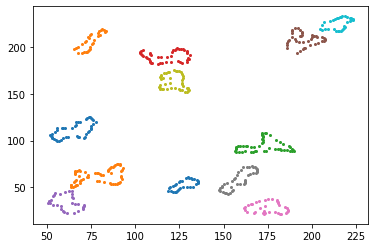

In [ ]:
for frame in interfacial_particles_frames:
  for group in frame:
    plt.plot(*group.T[1:3], 'o', ms = 2)
  plt.show()
  break

In [ ]:
sorted_particles_frames = []
for frame in interfacial_particles_frames:
    sorted_particles_group = []
    for group in frame:
        sorted_particles = sort_particles(group[:,1:3], 20)
        sorted_particles_group.append(np.array(sorted_particles))
    #     plt.plot(*sorted_particles.T[:2], '-o', mfc = 'k', ms = 3)
    # plt.show()
    sorted_particles_frames.append(np.array(sorted_particles_group))
sorted_particles_frames = np.array(sorted_particles_frames)

##**Curvature**

In [ ]:
curv_interface_frames = []; curv_std_frames = []; curv_all = []
for frame in sorted_particles_frames:
    curv_interface_group = []; curv_std_group = []
    for interface in frame:
        curv_interface = []
        for i in range(1, len(interface)-1):
            p1 = interface[i-1]
            p2 = interface[i]
            p3 = interface[i+1]
            centre, radius = define_circle(p1, p2, p3)
            curv_interface.append(1/radius)
            curv_all.append(1/radius)
        curv_interface_group.append(curv_interface)
        curv_std_group.append(np.std(curv_interface))
    curv_interface_frames.append(curv_interface_group)
    curv_std_frames.append(curv_std_group)

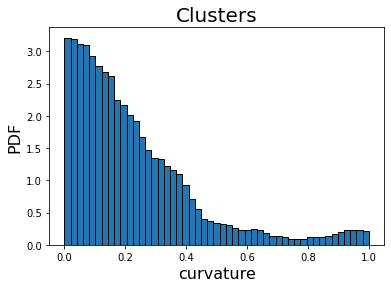

In [ ]:
bins = np.linspace(0, 1.0, 50)
plt.hist(curv_all, bins = bins, ec = 'k', density= True)
plt.xlabel('curvature', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.title('Clusters', fontsize = 20)
plt.savefig('PDF_curvature_clusters_simulation.png', dpi = 150)


#**Comparison**

##Curvature

In [ ]:
with open('PDF_curvature_clusters.pickle', 'rb') as file:
  data_clusters = pickle.load(file)
with open('PDF_curvature_slab.pickle', 'rb') as file:
  data_slab = pickle.load(file)

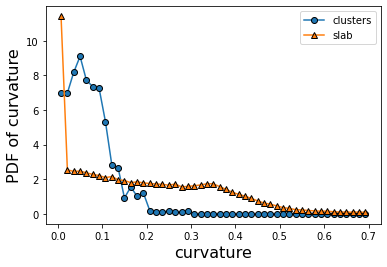

In [ ]:
plt.plot(*data_clusters.T, '-o', label = 'clusters', mec = 'k')
plt.plot(*data_slab.T, '-^', label = 'slab', mec = 'k')
plt.legend()
plt.xlabel('curvature', fontsize = 16)
plt.ylabel('PDF of curvature', fontsize = 16)
plt.savefig('PDF_curvature.png', dpi = 150)

In [ ]:
cluster_size = [150, 500, 1000, 2000, 3000]
datas = []
for i in cluster_size:
  with open('/content/drive/MyDrive/Paperwork/Colab/data/Curvature/PDF_curvature_clusters_%s.pickle'%(i), 'rb') as file:
    datas.append(pickle.load(file))

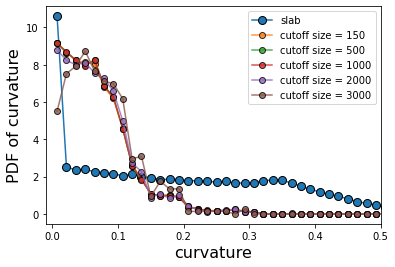

In [ ]:
with open('/content/drive/MyDrive/Paperwork/Colab/data/Curvature/PDF_curvature_slab.pickle', 'rb') as file:
  data_slab = pickle.load(file)
plt.plot(*data_slab.T, '-o', label = 'slab', mec = 'k', ms = 8)
for i in range (len(cluster_size)):
  plt.plot(*datas[i].T, '-o', mec = 'k', label = 'cutoff size = %s'%(cluster_size[i]), alpha = 0.8)
plt.legend()
plt.xlim((-0.01, 0.5))
plt.xlabel('curvature', fontsize = 16)
plt.ylabel('PDF of curvature', fontsize = 16)
plt.savefig('PDF_curvature_final.png', dpi = 150)